# Case Study 3 - Email Spam

__Team Members:__ Amber Clark, Andrew Leppla, Jorge Olmos, Paritosh Rai

# Team Strategy

Emails are read in.  Kept: From, Subject, Body.
- Remove \n with regex
- Remove other non-alphabetic characters - keep the counts?

Feature Extraction:
1. Vectorization - TFIDF (removes stop words)
If we have time:
2. Created 'trusted' and 'spam' email address book to filter spam - IS THIS OUT OF SCOPE PER SCOPE?

Model:
Classification with Naive Bayes - Amber, Jorge
1. Subject Only = Baseline
2. Body (+Subject?)

Clustering:
DBSCAN with cosine distance for NLP - Andrew, Paritosh

# Content
* [Business Understanding](#business-understanding)
    - [Scope](#scope)
    - [Introduction](#introduction)
    - [Methods](#methods)
    - [Results](#results)
* [Data Evaluation](#data-evaluation)
    - [Loading Data](#loading-data) 
    - [Data Summary](#data-summary)
    - [Missing Values](#missing-values)
    - [Feature Removal](#feature-removal)
    - [Exploratory Data Analysis (EDA)](#eda)
    - [Assumptions](#assumptions)
* [Model Preparations](#model-preparations)
    - [Sampling & Scaling Data](#sampling-scaling-data)
    - [Proposed Method](#proposed-metrics)
    - [Evaluation Metrics](#evaluation-metrics)
    - [Feature Selection](#feature-selection)
* [Model Building & Evaluations](#model-building)
    - [Sampling Methodology](#sampling-methodology)
    - [Model](#model)
    - [Performance Analysis](#performance-analysis)
* [Model Interpretability & Explainability](#model-explanation)
    - [Examining Feature Importance](#examining-feature-importance)
* [Conclusion](#conclusion)
    - [Final Model Proposal](#final-model-proposal)
    - [Future Considerations and Model Enhancements](#model-enhancements)
    - [Alternative Modeling Approaches](#alternative-modeling-approaches)

# Business Understanding & Executive Summary <a id='business-understanding'/>

What are we trying to solve for and why is it important?


### Scope <a id='scope'/>


### Introduction <a id='introduction'/>


### Methods <a id='methods'/>
 
 
### Results <a id='results'/>
 

# Data Evaluation <a id='data-evaluation'>
    

Summarize data being used?

Are there missing values?

Which variables are needed and which are not?

What assumptions or conclusions are you drawing about your data?

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import re
import os
from IPython.display import Image

# email
from email import policy
from email.parser import BytesParser

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

# clustering
from sklearn.cluster import DBSCAN
from statistics import stdev

# prediction models
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# import warnings filter
'''import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)'''

"import warnings\nwarnings.filterwarnings('ignore')\nfrom warnings import simplefilter \nsimplefilter(action='ignore', category=FutureWarning)"

## Loading Data <a id='loading-data'>

In [5]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [6]:
nb_name

'case_study3_template.ipynb'

In [7]:
import os
notebook_path = os.path.abspath(nb_name)

In [8]:
notebook_path

'C:\\Users\\allep\\QTW_Projects\\QTW-SPRING-2022\\ds7333_case_study_3\\case_study3_template.ipynb'

In [9]:
file_spam = os.path.join(os.path.dirname(notebook_path), "SpamAssassinMessages")

In [10]:
file_spam

'C:\\Users\\allep\\QTW_Projects\\QTW-SPRING-2022\\ds7333_case_study_3\\SpamAssassinMessages'

In [11]:
def get_all_files(folder):
    file_list = []
    if os.path.exists(folder):
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_list.append(os.path.join(root,file))
    return file_list

In [12]:
folders = os.listdir(file_spam)
folders

['easy_ham', 'easy_ham_2', 'hard_ham', 'spam', 'spam_2']

In [13]:
# Get the file names in each folder (list of lists)
files = [ os.listdir(file_spam+ '/'+ folder) for folder in folders] 

# Create a list of dataframes for all of the folders
emails = [ pd.DataFrame({'folder' : [], 'from' : [], 'subject' : [], 'body': []}) ]*len(folders)

# Add folder path to file names
for i in range(0,len(folders)):
    for j in range(0, len(files[i])):
        files[i][j] = str(file_spam +'/' + folders[i] + '/' + files[i][j]) 
        
        # Parse and extract email 'subject' and 'from'
        with open(files[i][j], 'rb') as fp:
            msg = BytesParser(policy=policy.default).parse(fp)
            
            # Error checking when reading in body for some html-based emails from spam folders
            try:
                simplest = msg.get_body(preferencelist=('plain', 'html'))
                try:
                    new_row = {'folder': folders[i], 'from': msg['from'], 'subject': msg['subject'], 'body': simplest.get_content()}
                    emails[i] = emails[i].append(new_row, ignore_index=True)
                except:
                    new_row = {'folder': folders[i], 'from': msg['from'], 'subject':msg['subject'], 'body':'Error(html)'}
                    emails[i] = emails[i].append(new_row, ignore_index=True)
            except:
                new_row = {'folder': folders[i], 'from': msg['from'], 'subject':msg['subject'], 'body':'Error(html)'}
                emails[i] = emails[i].append(new_row, ignore_index=True)

In [ ]:
# Emails per folder
print("# files in folders:", [len(i) for i in files])
print("# emails read in  :", [i.shape[0] for i in emails])

# Total emails
print( "\n# total emails =", sum([len(i) for i in files]) )

In [14]:
# Create single dataframe from all folders
df = pd.concat( [emails[i] for i in range(0, len(emails))], axis=0)

#  Keep the indices from the folders
df = df.reset_index() 

# create response column from folder names
spam = [(i=='spam' or i=='spam_2') for i in df['folder']]
df = pd.concat([df, pd.Series(spam).astype(int)], axis=1)

df.columns = ['folder_idx', 'folder', 'from', 'subject', 'body','spam']

df.shape

(9353, 6)

In [ ]:
df.head()

In [15]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

In [16]:
def cleanAndSplit(raw_text): 
    temp = []
    for word in raw_text.split():
        temp.append(re.sub(r"[^a-zA-Z0-9]","",word).lower())
    return temp

In [17]:
def cleanBody(raw_content):
    if(pd.isna(raw_content)):
        return []
    clean_from_html = cleanhtml(raw_content)
    out = cleanAndSplit(clean_from_html)
    return out

In [18]:
def combine(content):
    #joined = [*content[], *content]
    #print(content[['clean_body']])
    #print(content[['clean_subject']])
    #joined = content[['clean_body']], content[['clean_subject']]
    joined = np.concatenate((*content[['clean_body']], *content[['clean_subject']]))
    #print(joined)
    return joined

In [19]:
df['clean_body'] = df['body'].apply(cleanBody)

In [20]:
df['clean_subject'] = df['subject'].apply(cleanBody)

In [21]:
df['joined'] = df[['clean_body','clean_subject']].agg(combine, axis=1)

In [22]:
df.head()

,folder_idx,folder,from,subject,body,spam,clean_body,clean_subject,joined
0,0,easy_ham,Robert Elz <kre@munnari.OZ.AU>,Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0,"[date, wed, 21, aug, 2002, 105446, 0500, from,...","[re, new, sequences, window]","[date, wed, 21, aug, 2002, 105446, 0500, from,..."
1,1,easy_ham,Steve Burt <Steve_Burt@cursor-system.com>,[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,"[martin, a, posted, tassos, papadopoulos, the,...","[zzzzteana, re, alexander]","[martin, a, posted, tassos, papadopoulos, the,..."
2,2,easy_ham,Tim Chapman <timc@2ubh.com>,[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,"[man, threatens, explosion, in, moscow, thursd...","[zzzzteana, moscow, bomber]","[man, threatens, explosion, in, moscow, thursd..."
3,3,easy_ham,Monty Solomon <monty@roscom.com>,[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,"[klez, the, virus, that, wont, die, already, t...","[irr, klez, the, virus, that, wont, die]","[klez, the, virus, that, wont, die, already, t..."
4,4,easy_ham,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,"[, in, adding, cream, to, spaghetti, carbonara...","[re, zzzzteana, nothing, like, mama, used, to,...","[, in, adding, cream, to, spaghetti, carbonara..."


## Data Summary <a id='data-summary'>

## Missing Values <a id='missing-values'>



In [ ]:
# Rows where body couldn't be read in = 'Error(html)'
df.loc[df['body']=='Error(html)']

# All spam emails

In [ ]:
# Count of body read Errors
df.loc[df['body']=='Error(html)'].shape[0]

In [ ]:
# Look at file example with Error(html)
with open(files[4][1], 'rb') as fp:
    msg = BytesParser(policy=policy.default).parse(fp)
print(msg)

In [ ]:
df.isna().sum()

In [23]:
# Replace NaN and None values with 'No Subject'
df.loc[ df['subject'].isna(), 'subject'] = 'No Subject'
df.loc[ df['subject']=='', 'subject'] = 'No Subject'

## Feature Removal <a id='feature-removal'>

## Exploratory Data Analysis (EDA) <a id='eda'>

In [24]:
df['spam'].value_counts()

0    6954
1    2399
Name: spam, dtype: int64

### Clustering
- Use DBSCAN with cosine distance for NLP.  
- Try to keep the clusters balanced and get approx. 5 clusters to dissect and explain
- Look for descriptors for the clusters, like business vs. personal emails, IT emails, etc.

### 

In [25]:
def dummy_fun(doc):
    return doc
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)

In [26]:
#tfidf = TfidfVectorizer(stop_words='english', strip_accents='unicode', lowercase=True)

features_subject = vectorizer.fit_transform(df['clean_subject'])

## Andrew to replace stdev with node purity calcs

In [27]:
dbscan = DBSCAN(metric='cosine', min_samples=125)
eps_clusters = []

for j in range(50,101,50):
    dbscan.min_samples = j
    for i in range(65,81,5):
        dbscan.eps = i/100
        clustering = dbscan.fit_predict(features_subject)
        cluster_counts = list( pd.Series( clustering ).value_counts().sort_index() )
        cluster_counts.pop(0) # remove -1 cluster which is a non-cluster 
        num_clusters = len(cluster_counts)
        eps_clusters.append([ dbscan.min_samples, dbscan.eps, cluster_counts, num_clusters, stdev(cluster_counts) ])

clusters_df = pd.DataFrame(eps_clusters, columns = ['min_samples','epsilon', 'cluster counts', '# clusters','count stdev'])
clusters_df.sort_values(by=['# clusters', 'count stdev'])

,min_samples,epsilon,cluster counts,# clusters,count stdev
7,100,0.80,"[4497, 131]",2,3087.228207
5,100,0.70,"[133, 761, 124]",3,365.201771
6,100,0.75,"[1752, 133, 111, 123]",4,814.882967
2,50,0.75,"[3783, 133, 52, 54]",4,1852.050845
3,50,0.80,"[6529, 131, 31, 2]",4,3237.638272
4,100,0.65,"[133, 147, 140, 103, 155]",5,19.969977
1,50,0.70,"[70, 133, 73, 1775, 51, 50, 37, 50]",8,604.846247
0,50,0.65,"[70, 133, 70, 147, 51, 50, 163, 275, 35, 59, 2...",12,82.362098


## Final Clusters - Insights

5 clusters with stdev=90 (min_samples=100, epsilon=0.65) was by far the most balanced set of clusters with 100-150 emails in each cluster.

- Cluster 0 : News & Dates
- Cluster 1 : Pain (Ouch, hurts)
- Cluster 2 : [Spambayes] 
- Cluster 3 : IT
- Cluster 4 : [Spambayes] & package

In [29]:
# Most clusters with the lowest spread (stdev) in cluster counts
dbscan.min_samples = 100
dbscan.eps = 0.65

clusters = dbscan.fit_predict(features_subject)
clusters = pd.Series(clusters)
clusters.index = df.index
subject_clusters = pd.concat([ clusters, df['clean_subject'], df['spam'] ], axis=1)
subject_clusters.columns = ['cluster','clean_subject', 'spam']

heads_tails = pd.DataFrame({'cluster' : [], 'clean_subject' : [], 'spam' : []}) 
for i in range( 0, max(clusters.unique())+1 ): # Exclude the -1 class which is a non-cluster
    heads_tails = pd.concat([heads_tails, 
                             subject_clusters.loc[subject_clusters['cluster']==i].head(3),
                             subject_clusters.loc[subject_clusters['cluster']==i].tail(3) ], axis=0)
heads_tails[['cluster', 'spam']] = heads_tails[['cluster','spam']].astype(int)
print('Head & tail of each cluster:')    
heads_tails

Head & tail of each cluster:


,cluster,clean_subject,spam
65,0,"[use, perl, headlines, for, 20020830]",0
69,0,"[ntk, now, 20020830]",0
140,0,"[use, perl, headlines, for, 20021008]",0
6432,0,"[use, perl, stories, for, 20020820]",0
6661,0,"[use, perl, stories, for, 20020818]",0
6878,0,"[use, perl, stories, for, 20020818]",0
329,1,"[re, ouch, ouch, ouch, ouch, ouchwas, re, my, ...",0
340,1,"[re, ouch, ouch, ouch, ouch, ouchwas, re, my, ...",0
467,1,[ouch],0
5900,1,"[re, my, brain, hurts]",0


### 83 spam cases, all in Cluster 4.  Clusters 0-3 have no spam and can be used for filtering or pre-processing

In [33]:
subject_clusters.loc[subject_clusters['cluster']!=-1,'spam'].value_counts()

0    595
1     83
Name: spam, dtype: int64

In [32]:
subject_clusters.loc[subject_clusters['cluster']==4,'spam'].value_counts()

1    83
0    72
Name: spam, dtype: int64

### Feature Collinearity <a id='feature-collinearity'>


### Feature Outliers 
 

## Assumptions <a id='assumptions'>

# Model Preparations <a id='model-preparations'/>

What methods did you use (or not) to solve the problem?

Why are the methods you chose appropriate given the business objective?

How did you decide your approach was useful?  If more than one method, which one was better or why are each better or not?

What evaluation smetrics are most useful given the problem is a binary classification (ex. accuracy, f1-score, precision, recall AUC, etc)?



## Sampling & Scaling Data <a id='sampling-scaling-data' />

## Proposed Method <a id='proposed-metrics' />

## Evaluation Metrics <a id='evaluation-metrics' />

### Baseline Model

## Feature Selection <a id='feature-selection' />

# Model Building & Evaluations <a id='model-building'/>

Primary task is buiding a logistic regression to predict hospital readmittances.

How did you handle missing values?

Specify your sampling methodology

Set up your models - highlights of any important parameters

Analysis of your models performance

## Split into training and test

In [35]:
def split_dependant_and_independant_variables(df: pd.DataFrame, y_var: str):
    X = df.copy()
    y = X[y_var]
    X = X.drop([y_var], axis=1)
    return X, y

In [36]:
def shuffle_split(X, y, test_size, random_state):
    stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in stratified_shuffle_split.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

In [37]:
X, y = split_dependant_and_independant_variables(df, 'spam')

In [38]:
X_train, X_test, y_train, y_test = shuffle_split(X, y, test_size=0.3, random_state=12343)

### Base Naive Bayes

Team drew inspriation from https://towardsdatascience.com/training-a-naive-bayes-model-to-identify-the-author-of-an-email-or-document-17dc85fa630a

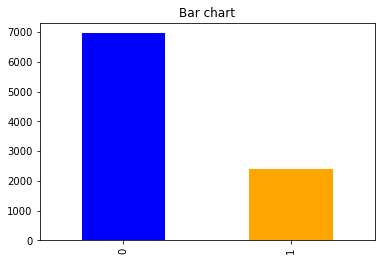

In [39]:
count_Class=pd.value_counts(df["spam"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

In [40]:
def dummy_fun(doc):
    return doc

In [41]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)

In [42]:
features_subject_train = vectorizer.fit_transform(X_train['clean_subject'])
features_subject_test = vectorizer.transform(X_test['clean_subject'])

In [43]:
features_subject_train

<6547x6105 sparse matrix of type '<class 'numpy.float64'>'
	with 37731 stored elements in Compressed Sparse Row format>

In [44]:
features_body_train = vectorizer.fit_transform(X_train['clean_body'])
features_body_test = vectorizer.transform(X_test['clean_body'])

In [45]:
features_body_train

<6547x84850 sparse matrix of type '<class 'numpy.float64'>'
	with 974741 stored elements in Compressed Sparse Row format>

In [46]:
from scipy import sparse
features_joined_train = sparse.hstack((features_subject_train, features_body_train), format='csr') 
features_joined_test = sparse.hstack((features_subject_test, features_body_test), format='csr') 

In [47]:
features_joined_train

<6547x90955 sparse matrix of type '<class 'numpy.float64'>'
	with 1012472 stored elements in Compressed Sparse Row format>

## Feature Selection
Only need 1% (or less) of the features to predict spam without overfitting.  This runs really fast.

In [34]:
selector = SelectPercentile(f_classif, percentile=1)

In [163]:
selector.fit(features_subject_train, y_train)
features_subject_train_sel = selector.transform(features_subject_train).toarray()
features_subject_test_sel = selector.transform(features_subject_test).toarray()

In [164]:
features_subject_train_sel.shape

(6547, 62)

In [165]:
selector.fit(features_body_train, y_train)
features_body_train_sel = selector.transform(features_body_train).toarray()
features_body_test_sel = selector.transform(features_body_test).toarray()

In [166]:
features_body_train_sel.shape

(6547, 848)

In [167]:
selector.fit(features_joined_train, y_train)
features_joined_train_sel = selector.transform(features_joined_train).toarray()
features_joined_test_sel = selector.transform(features_joined_test).toarray()

In [168]:
features_joined_train_sel.shape

(6547, 910)

## Modeling

In [152]:
# Baseline accuracy of 74% with class imbalance
df['spam'].value_counts(normalize=True)

0    0.743505
1    0.256495
Name: spam, dtype: float64

In [58]:
# All subject features - overfits training set by 5.5%
model1a = GaussianNB()
features_subject_train1 = features_subject_train.toarray()
features_subject_test1 = features_subject_test.toarray()
model1a.fit(features_subject_train1, y_train)
score_train = model1a.score(features_subject_train1, y_train)
score_test = model1a.score(features_subject_test1, y_test)
print("Train Subject Accuracy:", score_train)
print("Test Subject Accuracy:", score_test)

Train Subject Accuracy: 0.9761722926531236
Test Subject Accuracy: 0.9237348538845331


In [169]:
# 1% of subject features - no overfitting
model1b = GaussianNB()
model1b.fit(features_subject_train_sel, y_train)
score_train = model1b.score(features_subject_train_sel, y_train)
score_test = model1b.score(features_subject_test_sel, y_test)
print("Train Subject Accuracy:", score_train)
print("Test Subject Accuracy:", score_test)

Train Subject Accuracy: 0.8312204062929586
Test Subject Accuracy: 0.8296507483962936


In [170]:
# 1% of body features
model2 = GaussianNB()
model2.fit(features_body_train_sel, y_train)
score_train = model2.score(features_body_train_sel, y_train)
score_test = model2.score(features_body_test_sel, y_test)

In [171]:
# overfits training set by just 1% accuracy
print("Train Body Score:", score_train)
print("Test Body Score:", score_test)

Train Body Score: 0.9596761875668245
Test Body Score: 0.9490377761938703


In [183]:
# 0.1% of body features
selector = SelectPercentile(f_classif, percentile=0.1)
selector.fit(features_body_train, y_train)
features_body_train_sel = selector.transform(features_body_train).toarray()
features_body_test_sel = selector.transform(features_body_test).toarray()
model2b = GaussianNB()
model2b.fit(features_body_train_sel, y_train)
score_train = model2b.score(features_body_train_sel, y_train)
score_test = model2b.score(features_body_test_sel, y_test)
print("Train Body Score:", score_train)
print("Test Body Score:", score_test)

Train Body Score: 0.9225599511226515
Test Body Score: 0.9215965787598004


In [172]:
# 1st percentile of subject + body features
model3 = GaussianNB()
model3.fit(features_joined_train_sel, y_train)
score_train = model3.score(features_joined_train_sel, y_train)
score_test = model3.score(features_joined_test_sel, y_test)

In [173]:
# overfits training set by just 1%
print("Train Body Score:", score_train)
print("Test Body Score:", score_test)

Train Body Score: 0.9601344127081106
Test Body Score: 0.9493941553813258


In [184]:
# 0.1% of subject + body features, similar to body only, not worth the complexity
selector = SelectPercentile(f_classif, percentile=0.1)
selector.fit(features_joined_train, y_train)
features_joined_train_sel = selector.transform(features_joined_train).toarray()
features_joined_test_sel = selector.transform(features_joined_test).toarray()
model2b = GaussianNB()
model2b.fit(features_joined_train_sel, y_train)
score_train = model2b.score(features_joined_train_sel, y_train)
score_test = model2b.score(features_joined_test_sel, y_test)
print("Train Body Score:", score_train)
print("Test Body Score:", score_test)

Train Body Score: 0.9230181762639377
Test Body Score: 0.9215965787598004


## Sampling Methodology <a id='sampling-methodology'/>

#### Per the code above we used a 70/30 train test sample split

## Model's Performance Analysis <a id='performance-analysis'/>

# Model Interpretability & Explainability <a id='model-explanation'>

Which variables were more important and why?

How did you come to the conclusion these variables were important how how should the audience interpret this?

## Examining Feature Importance <a id='examining-feature-importance'/>

# Conclusion <a id='conclusion'>

What are you proposing to the audience with your models and why?

How should your audience interpret your conclusion and whwere should they go moving forward on the topic?

What other approaches do you recommend exploring?

Bring it all home!

### Final Model Proposal <a id='final-model-proposal'/>

### Future Considerations and Model Enhancements <a id='model-enhancements'/>

### Alternative Modeling Approaches <a id='alternative-modeling-approaches'>